# Рекомендация тарифов

## Цели проекта

Построить модель для задачи классификации, которая поможет оператору мобильной связи «Мегалайн» построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Ход работы

1. Познакомиться с данными из датасета `users_behavior.csv`.
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры. Описать выводы исследования.
4. Проверить качество модели на тестовой выборке.

## Знакомство с данными

In [1]:
# import of library
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sbrn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
try:
    df = pd.read_csv("/datasets/users_behavior.csv")
except:
    df = pd.read_csv("users_behavior.csv")
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Можно поменять тип данных у столбцов *calls и messages* на целочисленное значение:

In [3]:
df["calls"] = df["calls"].astype("int")
df["messages"] = df["messages"].astype("int")
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0
5,58,344.56,21,15823.37,0
6,57,431.64,20,3738.90,1
7,15,132.40,6,21911.60,0
8,7,43.39,3,2538.67,1
9,90,665.41,38,17358.61,0


In [4]:
# number of duplicates
df.duplicated().sum()

0

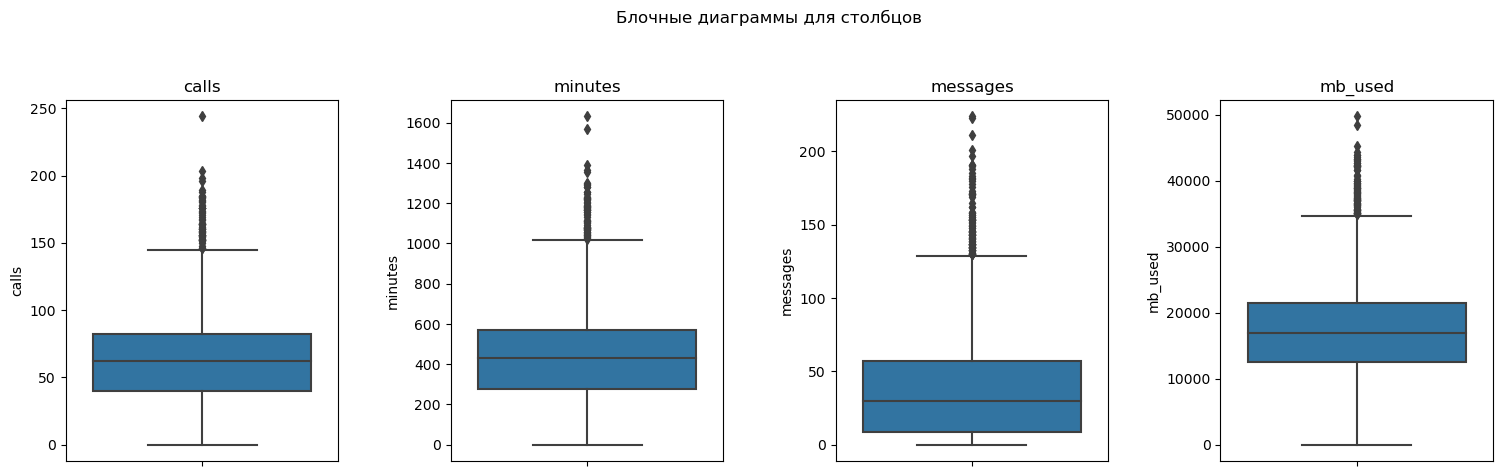

In [5]:
# subplot для столбцов
columns_plot = df.columns.to_list()
del columns_plot[4]

fig, axs = plt.subplots(1, len(columns_plot), figsize=(15, 5))
fig.tight_layout(w_pad=5)
col = 0
for i in columns_plot:
    ax = sbrn.boxplot(y=df[i], ax=axs[col])
    ax.set_title(i)
    col += 1
fig.suptitle("Блочные диаграммы для столбцов")
plt.subplots_adjust(top=0.8)

Пропусков нет, дубликатов нет, явных выбросов в данных нет, поменяли тип данных у столбцов с количеством вызовов и сообщений на целочисленный.

## Разбивка данных на выборки

In [6]:
features = df.drop("is_ultra", axis=1)  # признаки
target = df["is_ultra"]  # целевой признак

features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.6, random_state=12345
)  # отделим 60% данных для обучающей выборки выборки

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345
)  # отделим 50% от тестового набора на валидационный набор

print(
    "Количество объектов в обучающей выборке:",
    target_train.count(),
    ", в процентах: ",
    math.ceil(100 * target_train.count() / target.count()),
    "%",
)
print(
    "Количество объектов в тестовой выборке:",
    target_test.count(),
    ", в процентах: ",
    int(100 * target_test.count() / target.count()),
    "%",
)
print(
    "Количество объектов в валидационной выборке:",
    target_valid.count(),
    ", в процентах: ",
    int(100 * target_valid.count() / target.count()),
    "%",
)

Количество объектов в обучающей выборке: 1928 , в процентах:  60 %
Количество объектов в тестовой выборке: 643 , в процентах:  20 %
Количество объектов в валидационной выборке: 643 , в процентах:  20 %


## Исследование модели

В нашем случае целевой признак категориальный, причем категорий всего две (1 - тариф «Ультра», 0 - «Смарт»), значит будет решаться задача **бинарной классификации**.

### Дерево решений

#### max_depth

Рассмотрим модели "Дерево решений" с различной глубиной дерева и выберем модель с наилучшим значением метрики accuracy:

In [7]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("Accuracy лучшей модели:", round(best_result, 3))
print("Значение лучшей глубины дерева:", best_depth)

Accuracy лучшей модели: 0.799
Значение лучшей глубины дерева: 7


#### criterion

Далее настроим гиперпараметр *criterion* с *gini* на *entropy*:

In [8]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7, criterion="entropy")
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
print("Accuracy модели:", round(result, 3))

Accuracy модели: 0.796


Качество модели самую малость, но уступает модели с гиперпараметром criterion="gini", значит оставим *'gini'*.

#### splitter

Теперь поменяем гиперпараметр *splitter* с *best* на *random*:

In [9]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7, splitter="random")
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
print("Accuracy модели:", round(result, 3))

Accuracy модели: 0.776


Снова качество новой модели уступает модели с гиперпараметром splitter='best ', значит оставим 'best'.

#### Промежуточный итог

Поэксперементировали с гиперпараметрами splitter, criterion, max_depth. Пришли к выводу, что самые оптимальные значения:
* splitter = 'best' (по умолчанию)
* criterion = 'gini' (по умолчанию)
* max_depth = 7

Максимальное значение качества модели: **0.799**

### Cлучайный лес

#### max_depth, n_estimators

Рассмотрим модели "Cлучайный лес" с различной глубиной деревьев и их количеством и выберем модель с наилучшим значением метрики accuracy:

In [10]:
best_model = None
best_result = 0
best_depth = 0

n_three = 0
best_depth = 0
for est in range(1, 21):
    for depth in range(1, 11):
        model = RandomForestClassifier(
            random_state=12345, max_depth=depth, n_estimators=est
        )
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            n_three = est
print("Accuracy лучшей модели:", round(best_result, 3))
print("Значение лучшей глубины дерева:", best_depth)
print("Значение лучшего количества деревьев:", n_three)

Accuracy лучшей модели: 0.815
Значение лучшей глубины дерева: 9
Значение лучшего количества деревьев: 14


#### criterion

Далее снова поменяем гиперпараметр *criterion* с *gini* на *entropy*:

In [11]:
model = RandomForestClassifier(
    random_state=12345, max_depth=9, n_estimators=14, criterion="entropy"
)
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
print("Accuracy модели:", round(result, 3))

best_random_forest_model = best_model

Accuracy модели: 0.823


Качество модели улучшилось, значит остановимся на *'entropy'*.

#### bootstrap

Теперь изменим гиперпараметр bootstrap с True на False.

In [12]:
model = RandomForestClassifier(
    random_state=12345,
    max_depth=9,
    n_estimators=14,
    criterion="entropy",
    bootstrap=False,
)
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
print("Accuracy модели:", round(result, 3))

best_random_forest_model = best_model

Accuracy модели: 0.788


Качество модели ухудшилось, значит остановимся на значении True.

#### warm_start

Теперь изменим гиперпараметр warm_start с Flase на True. 

In [13]:
model = RandomForestClassifier(
    random_state=12345,
    max_depth=9,
    n_estimators=14,
    criterion="entropy",
    warm_start=True,
)
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
print("Accuracy модели:", round(result, 3))

Accuracy модели: 0.823


Значение качества не поменялось. Можно оставить все по умолчанию.

Сохраним лучшую модель с самыми оптимальными гиперпараметрами в переменную ***best_random_forest_model***:

In [14]:
model = RandomForestClassifier(
    random_state=12345, max_depth=9, n_estimators=14, criterion="entropy"
)
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)

best_random_forest_model = model

#### Промежуточный итог

Поэксперементировали с гиперпараметрами n_estimators, criterion, max_depth, bootstrap, warm_start. Пришли к выводу, что самые оптимальные значения:
* n_estimators = 14
* max_depth = 9
* bootstrap = True (по умолчанию)
* criterion = 'entropy'
* warm_start = False (по умолчанию)

Максимальное значение качества модели: **0.823**

### Логистическая регрессия

#### max_iter

Попробуем различные значения максимального количества итераций начиная от 50 до 10000 с шагом 50:

In [15]:
best_model = None
best_result = 0
best_max_iter = 0
for i in range(50, 10001, 50):
    model = LogisticRegression(random_state=12345, max_iter=i)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_max_iter = i
    if i == 50:
        print("Accuracy модели при max_iter=50: ", round(result, 5))
    if i == 100:
        print("Accuracy модели при max_iter=100: ", round(result, 5))
    if i == 1000:
        print("Accuracy модели при max_iter=1000: :", round(result, 5))
print("Accuracy лучшей модели:", round(best_result, 3))
print("Значение лучшего количества итераций:", best_max_iter)

Accuracy модели при max_iter=50:  0.68429
Accuracy модели при max_iter=100:  0.68429
Accuracy модели при max_iter=1000: : 0.68429
Accuracy лучшей модели: 0.684
Значение лучшего количества итераций: 50


Accuracy не отличаются, можно оставить значение max_iter самое большое из рассмотренных (10000).

#### solver

По умолчанию гиперпараметр *solver* имеет значение "lbfgs", проверим значения Accuracy с другими алгоритмами ['liblinear','newton-cg','sag']:

In [16]:
best_model = None
best_result = 0
best_solver = ""
for i in ["liblinear", "newton-cg", "sag"]:
    model = LogisticRegression(random_state=12345, max_iter=10000, solver=i)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_solver = i
print("Accuracy лучшей модели:", round(best_result, 3))
print("Значение лучшего solver:", best_solver)

Accuracy лучшей модели: 0.739
Значение лучшего solver: newton-cg


Качество модели улучшилось с алгоритмом *newton-cg*.

#### С

In [17]:
import warnings

warnings.filterwarnings("ignore")

best_model = None
best_result = 0
best_c = 1.0

for c in [x / 100 for x in range(1, 51, 2)]:
    model = LogisticRegression(
        random_state=12345, max_iter=10000, solver="newton-cg", C=c
    )
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_c = c
print("Accuracy лучшей модели:", round(best_result, 3))
print("Значение лучшего С:", best_c)
warnings.resetwarnings()

Accuracy лучшей модели: 0.739
Значение лучшего С: 0.01


Добиться улучшения метрики не удалось, оставляем 'C' по умолчанию 1.0.

#### Промежуточный итог

Поэксперементировали с гиперпараметрами max_iter, solver, С. Пришли к выводу, что самые оптимальные значения:
* max_iter = 10000
* solver = 'newton-cg'
* С = 1.0

Максимальное значение качества модели: **0.739**

### Вывод

Наилучшую метрику качества со значением **0.823** показала модель "Случайный лес"  со следующими гиперпараметрами: 
* n_estimators = 14
* max_depth = 9
* bootstrap = True (по умолчанию)
* criterion = 'entropy'
* warm_start = False (по умолчанию)

Сохранили эту модель в переменной *best_random_forest_model*.

## Проверка модели на тестовой выборке

In [18]:
result = best_random_forest_model.score(features_test, target_test)
print("Accuracy на тестовой выборке:", round(result, 3))

Accuracy на тестовой выборке: 0.804


Выбранная модель показала на тестовой выборке вполне себе высокую точность классификации **0.804**. Учитывая еще и то, что на валидационной выборке это значение было еще выше **0.823**, можно смело утверждать, что данную модель можно советовать оператору мобильной связи «Мегалайн». 

## Вывод

1. Ознакомились с данными, убедились в отсутствии дубликатов, выбросов.
2. Разбили выборку на три части: обучающую (60%), валидационную(20%), тестовую(20%).
3. Исследовали три типа модели обучения ("Дерево решений", "Случайный лес", "Логистическая регрессия") с разными гиперпараметрами. Пришли к выводу, что наибольшее значение метрики качества равное **0.823** показала модель "Случайный лес" cо следующими гиперпараметрами: 
* n_estimators = 14
* max_depth = 9
* bootstrap = True (по умолчанию)
* criterion = 'entropy'
* warm_start = False (по умолчанию)
4. Данная модель на тестовой выборке показала также высокую точность классификации **0.804**, что говорит о работоспособности модели.